In [2]:
import pandas as pd # needed for most operation
import numpy as np # needed for some array operations
from sqlalchemy import create_engine # needed for DB connection.
import matplotlib.pyplot as plt

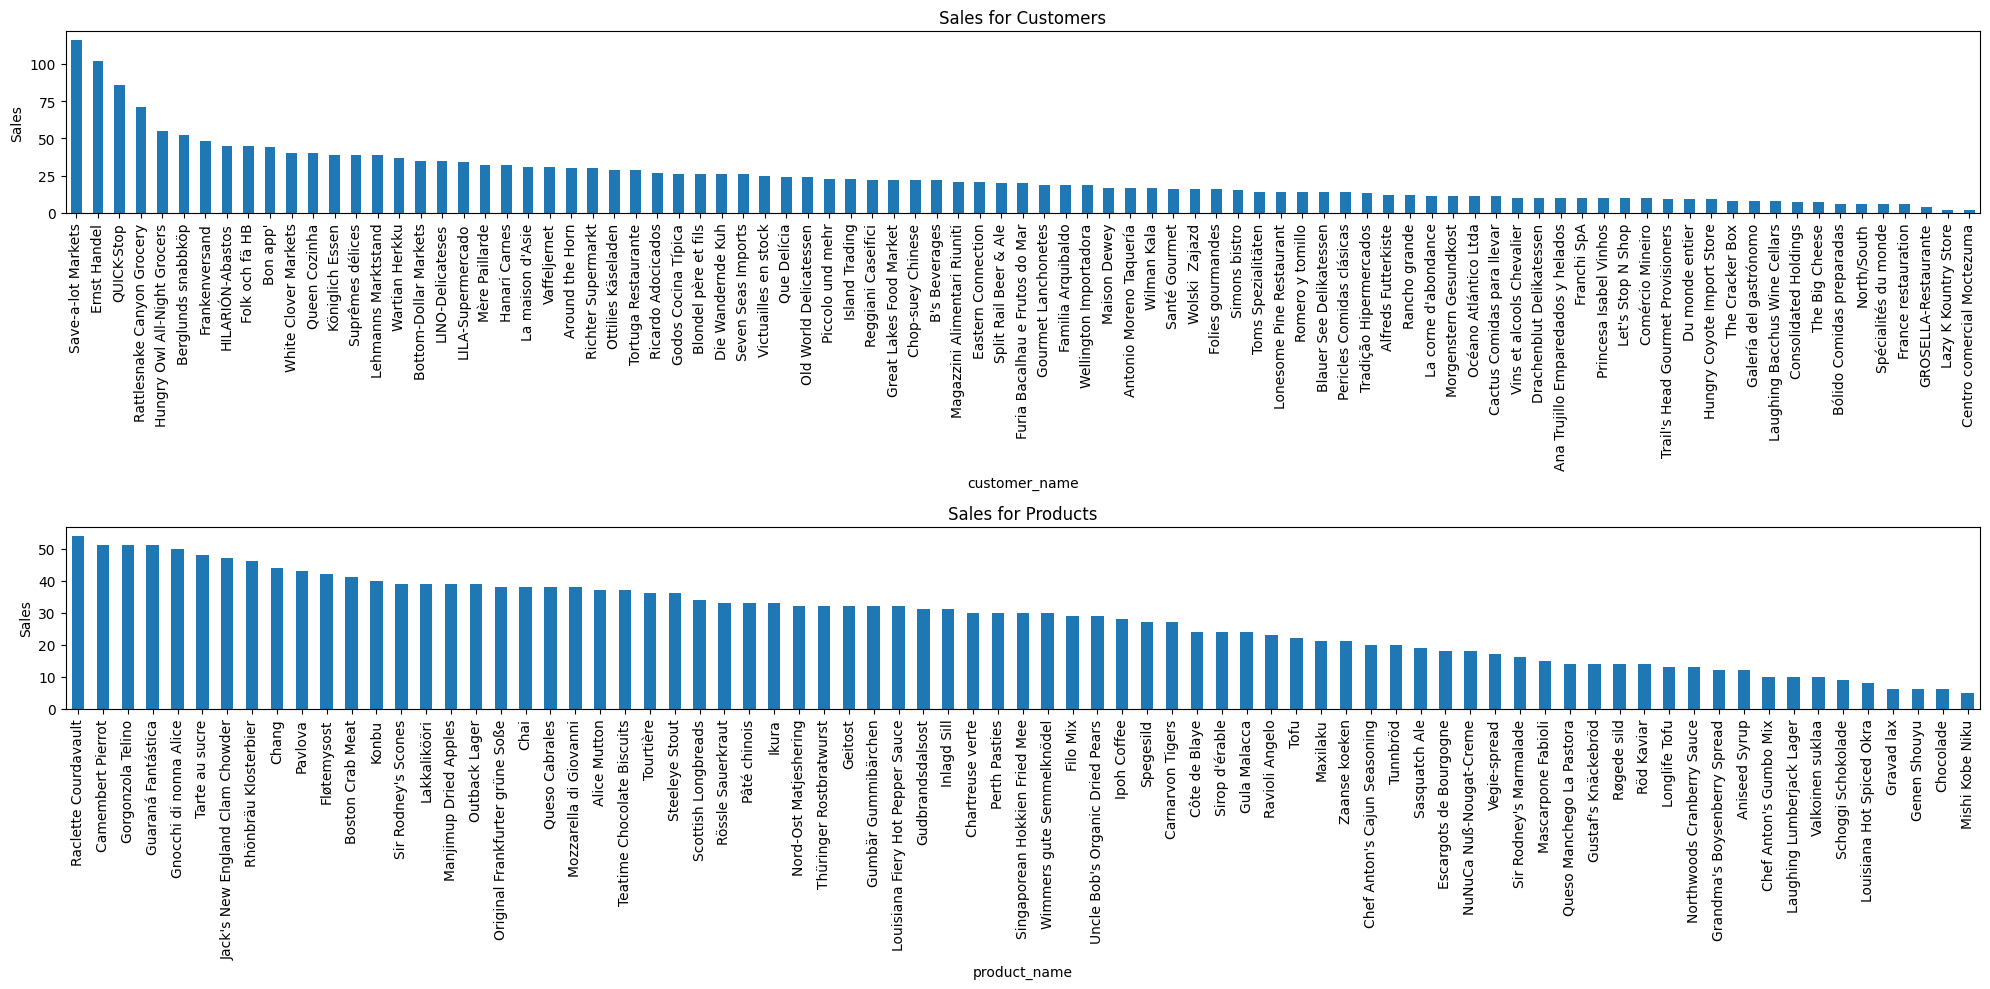

In [3]:

# read csv files
df = pd.read_csv('BI_Raw_Data.csv', encoding='ISO-8859-1')

#split the column
'''df[['Order_ID','Order_Date_Year','Order_Date_Month','Order_Date_Day',
    'Order_Price_Total','Customer_Name','Customer_Country','Product_Name',
    'Product_Category','Product_Order_Unit_Price','Product_Order_Quantity',
    'Product_Order_Price_Total']] \
= df['Order_ID;Order_Date_Year;Order_Date_Month;Order_Date_Day;Order_Price_Total;\
Customer_Name;Customer_Country;Product_Name;Product_Category;Product_Order_Unit_Price;\
Product_Order_Quantity;Product_Order_Price_Total'].str.split(';', expand=True)

df = df.drop(columns=['Order_ID;Order_Date_Year;Order_Date_Month;Order_Date_Day;Order_Price_Total;\
Customer_Name;Customer_Country;Product_Name;Product_Category;Product_Order_Unit_Price;\
Product_Order_Quantity;Product_Order_Price_Total'], errors='ignore')
df.to_csv('BI_Raw_Data.csv', index=False, encoding='ISO-8859-1', mode='w')
'''

#data process for product table
product = df.drop_duplicates(subset=['Product_Name','Product_Category'] , ignore_index=True, keep='last')
product = product[['Product_Name', 'Product_Category']].rename(columns={'Product_Name': 'product_name', 'Product_Category': 'category'})
product['productid'] = product.reset_index().index
product = product[['productid','product_name','category']]
product.to_csv('Product.csv', index=False, encoding='ISO-8859-1', mode='w')

#data process for customer table
customer = df.drop_duplicates(subset=['Customer_Name','Customer_Country'] , ignore_index=True, keep='last')
customer = customer[['Customer_Name', 'Customer_Country']].rename(columns={'Customer_Name': 'customer_name', 'Customer_Country': 'country'})
customer['customerid'] = customer.reset_index().index
customer = customer[['customerid','customer_name','country']]
customer.to_csv('Customer.csv', index=False, encoding='ISO-8859-1', mode='w')

#data process for sales table
sales = df.drop(columns=['Order_ID','Order_Date_Year','Order_Date_Month','Product_Order_Unit_Price','Product_Order_Quantity'], errors='ignore')
sales = pd.merge(sales, product, how='outer',left_on = ['Product_Name','Product_Category'],right_on = ['product_name','category'])\
    .drop(columns=['Product_Name', 'Product_Category', 'name','category'], errors='ignore')
sales = pd.merge(sales, customer, how='outer',left_on = ['Customer_Name','Customer_Country'],right_on = ['customer_name','country'])\
    .drop(columns=['Customer_Name','Customer_Country', 'name','country','Order_Price_Total'], errors='ignore')\
    .rename(columns={'Product_Order_Price_Total': 'sales', 'Order_Date_Day': 'orderdate'})
sales = sales[['productid','customerid','orderdate','sales']]
sales.to_csv('sales.csv', index=False, encoding='ISO-8859-1', mode='w')

# first create link to database
# Replace username with the user name password with the password
driver='postgresql'
username='dab_ds23241a_237'
dbname=username # it is the same as the username
password='yaiy2gzjumSdTfVA'
server='bronto.ewi.utwente.nl'
port='5432'
# Creating the connetcion pool for SQL
engine = create_engine(f'{driver}://{username}:{password}@{server}:{port}/{dbname}')
product.to_sql('product', engine,schema='ass2', index=False, if_exists='replace')
customer.to_sql('customer', engine,schema='ass2',index=False, if_exists='replace')
sales.to_sql('sales', engine,schema='ass2',index=False, if_exists='replace')

#Data visualization
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sales_withname = pd.merge(sales, customer, how = 'outer', left_on = ['customerid'], right_on=['customerid'])
sales_withname = pd.merge(sales_withname, product, how = 'outer', left_on = ['productid'], right_on=['productid'])
sales_withname.drop(columns=['category', 'country'], errors='ignore')\
    .to_csv('sales_withname.csv', index=False, encoding='ISO-8859-1', mode='w')

sales_withname['customer_name'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Sales for Customers')
axes[0].set_ylabel('Sales')

sales_withname['product_name'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Sales for Products')
axes[1].set_ylabel('Sales')

plt.tight_layout()
plt.show()

